# Contenuti
- [Scikit-image](#Scikit-image)
- [Import delle librerie](#Import-delle-librerie)
- [Caricamento del dataset](#Caricamento-del-dataset)
- [Classificazione a partire dai pixel](#Classificazione-a-partire-dai-pixel)
- [Estrazione delle feature (HOG)](#Estrazione-delle-feature-%28HOG%29)
- [Addestramento del classificatore](#Addestramento-del-classificatore)
- [Esercizio](#Esercizio)
- [Test](#Test)

# Esercitazione 4
Nell'esercitazione odierna si applicheranno diversi algoritmi classici di Machine Learning (*SVM*, *k-NN*, *Random Forest* e *AdaBoost*) a un problema di classificazione binario di **immagini RGB** raffiguranti cani e gatti.

Al fine di manipolare e adattare le immagini verranno utilizzate alcune funzionalità messe a disposizione dalla libreria **Scikit-image**. 

Nel corso dell'esercitazione si dovranno individuare l'algoritmo e le combinazioni di iperparametri che permettono di massimizzare l’accuratezza sul dataset fornito. A tal fine si faccia riferimento alle tecniche viste nell'ambito dell'esercitazione precedente.

Infine si dovrà verificare l'accuratezza della soluzione trovata sul dataset di test per provarne l’effettiva capacità di generalizzazione.

# Scikit-image
Scikit-image è una libreria Python che mette a disposizione numerose classi e funzionalità per l'elaborazione di immagini.

Condivide con Scikit-learn la facilità d'uso, l'ampia possibilità di parametrizzare le operazioni messe a disposizione e l'integrazione con la libreria Numpy. Allo stesso modo lo stile della documentazione e della API è estremamente simile a quello di Scikit-learn.

Per una lista completa delle funzionalità si rimanda alla [documentazione ufficiale](http://scikit-image.org/docs/stable/).

# Import delle librerie
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione. Il modulo necessario per utilizzare la libreria Scikit-image si chiama **skimage**.

In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from skimage import feature, color, transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import ml_utilities
import ml_visualization

# Caricamento del dataset
Il dataset consiste in un insieme di immagini RGB di cani e gatti. Prima di caricarlo è necessario definire:
- il percorso in cui sono memorizzate le immagini dei dataset (*db_path*);
- il percorso di una cartella di lavoro (*exp_path*) dove, durante l'elaborazione, saranno memorizzati file intermedi;
- il path del file contenente la lista delle immagini e relative etichette di classe da utilizzare come training set (*train_filelist*).

Caricamento in corso ...
Caricate 900 immagini in 0.15 s.
Gatti: 509
Cani: 391


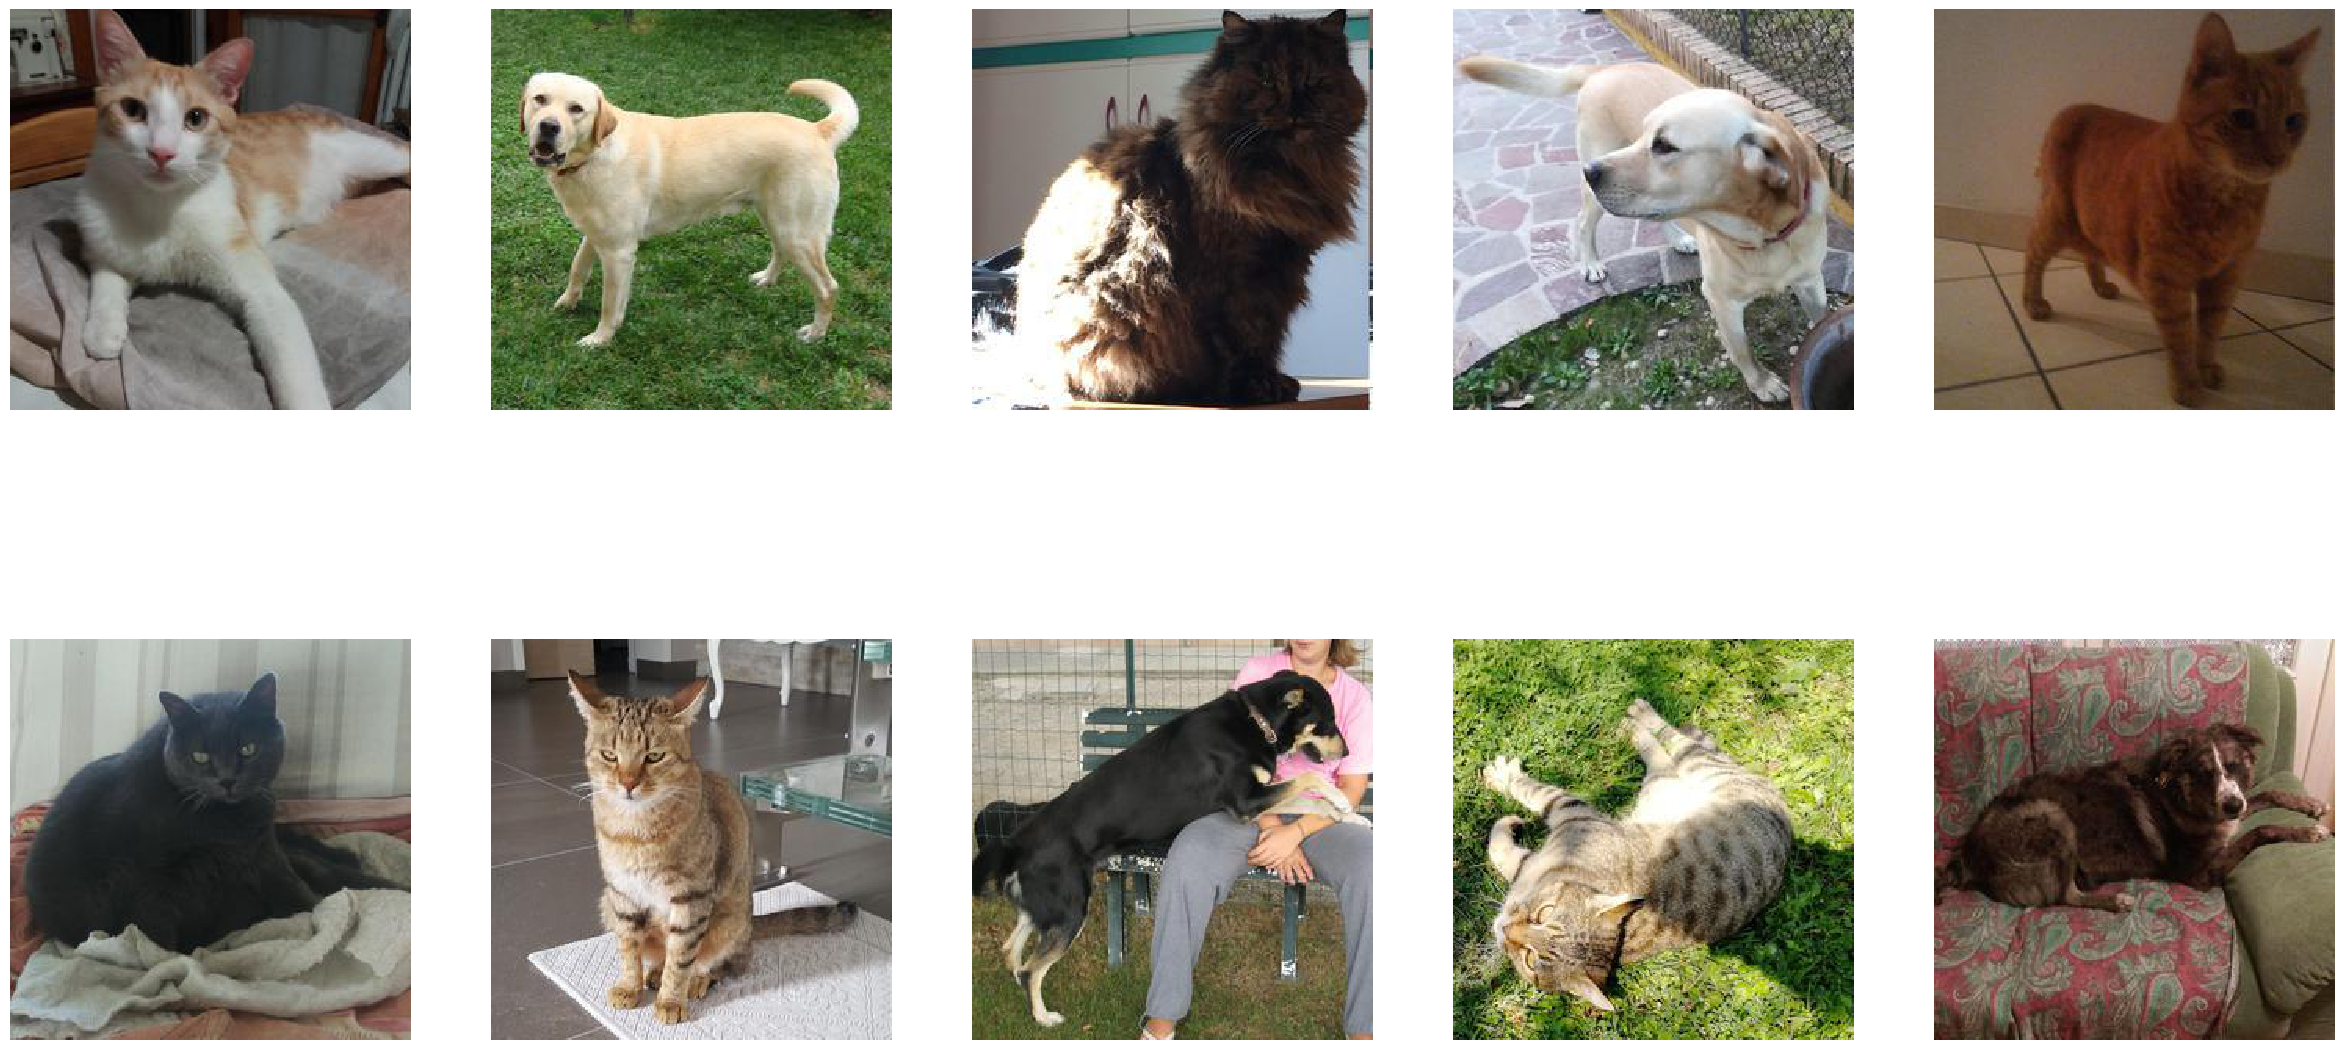

In [2]:
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt'  

# Predisposizione di un'area di caching su disco che velocizza la riesecuzione di chiamate di funzioni con gli stessi parametri
memory = Memory(exp_path, verbose=0)  

# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

print('Caricate %d immagini in %.2f s.' % (len(train_raw_x), time.time() - start))
print('Gatti:', np.count_nonzero(train_y == 0))
print('Cani:', np.count_nonzero(train_y == 1))

# Shuffle del training set
ml_utilities.shuffle_in_unison([train_raw_x, train_y], seed=1234)

# Visualizzazione immagini
_, axs = plt.subplots(2, 5,figsize=(30, 15))
for i in range(5):
    axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
    axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
plt.show()

Se le dimensioni delle immagini in input sono eterogenee, prima di poterle utilizzare è necessario portarle tutte a delle dimensioni prefissate ($\textit{image_side} \times \textit{image_side}$) come mostrato nella cella seguente.

Resizing in corso ...
Resizing completato in 0.32 s.


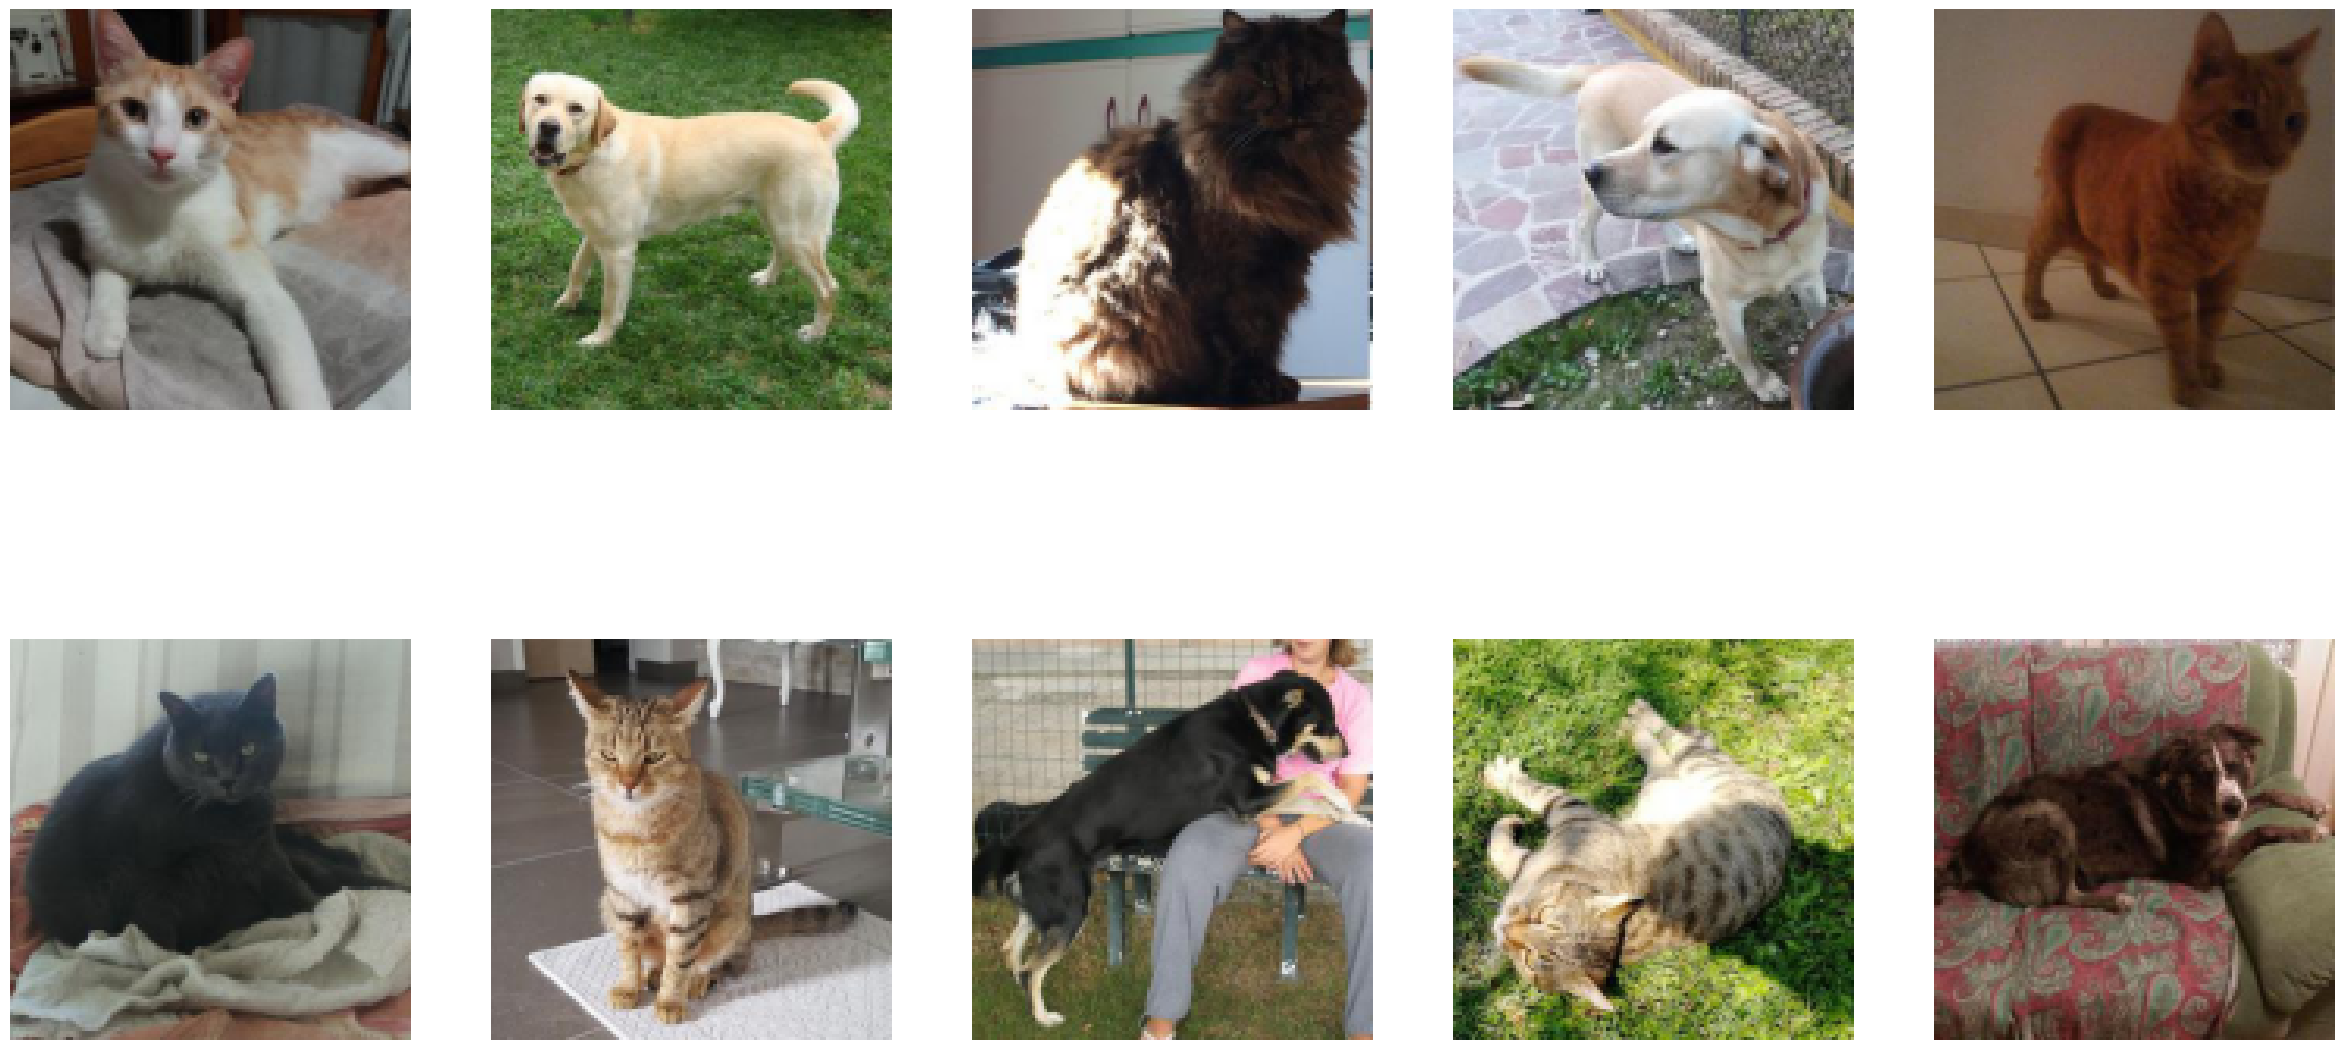

In [3]:
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))
    
    # Visualizzazione immagini
    _, axs = plt.subplots(2, 5,figsize=(30, 15))
    for i in range(5):
        axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
        axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
    plt.show()

# Classificazione a partire dai pixel

Le immagini ottenute (anche a seguito di *resizing*) sono molto grandi per poter essere utilizzate direttamente come input di un classificatore tradizionale. Infatti un'immagine $\textit{128} \times \textit{128} \times \textit{3}$ corrisponde a un pattern 49152-dimensionale.

Utilizzando un *SVM* il tempo di training è di circa 2 minuti (utilizzando la classe **LinearSVC** ottimizzata per *kernel* lineare) per ottenere un'accuratezza intorno al 57% (di poco superiore alla scelta casuale!).

Nel settore della visione artificiale per l'addestramento di classificatori (qualora non si utilizzino tecniche di deep learning quali le reti CNN) è prassi consolidata estrarre dalle immagini feature **robuste** e **compatte**.

Perchè l'intensità dei pixel non è una feature robusta?
<img src="pixel_dist.png" alt="" style="width: 600px;"/>

Variazioni di posa, e illuminazione possono rendere campioni della stessa classe molto diversi tra loro in termini di intensità di pixel corrispondenti.

Purtroppo non esiste un tipo di feature idoneo per tutti i problemi ma è necessario padroneggiare il dominio applicativo per scegliere/progettare in modo ottimale le feature da utilizzare (si parla di *feature engineering* o *handcrafted features*).

# Estrazione delle feature (HOG)
In questa esercitazione utilizzeremo le feature note come *Histogram of Oriented Gradients* ([HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)), originariamente introdotte per *pedestrian detection*, ma applicabili anche ad altri domini.

Un'implementazione è disponibile nella libreria  [Scikit-image](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog).

Per estrarre le orientazioni, il metodo HOG non ha evidenti vantaggi dall'uso del colore. Pertanto prima dell'estrazione le immagini possono essere convertite da RGB (3 byte per pixel) in scala di grigi (1 byte per pixel).

L'immagine viene suddivida in blocchi. Per ognuno di essi HOG estrae le orientazioni del gradiente e le riassume attraverso un istogramma. 

La funzione **hog(...)** restituisce un **ndarray** monodimensionale contenente le feature estratte. Con il paramentro opzionale (*visualise*) è possibile ottenerne una visualizzazione grafica utile per comprendere meglio la natura delle feature estratte. La cella seguente visualizza una rappresentazione HOG relativa a un'immagine di esempio.

In [4]:
# Canny edge detection
def find_edges(img):
    img = color.rgb2gray(img)
        
    # --- Svolgimento Esercizio 3: Inizio --- #
    
    (t1, t2, s) = (100,55,2)
    # Algoritmo di Canny con soglie t1 e t2
    edges = feature.canny(img, sigma=s)
    img_e = img.copy()
    #img_e[edges!=0] = (0,255,255)
    return edges

In [5]:
orig = train_raw_x[:]
train_raw_x = [find_edges(i) for i in train_raw_x]

Numero feature: 2304


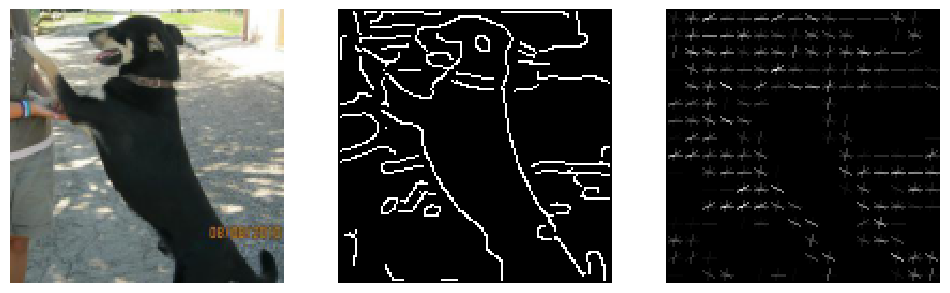

In [8]:
image_index = 12# Modificare con un indice a piacere

# Conversione in grayscale
grayscale_image = train_raw_x[image_index]

# Estrazione delle feature
hog_features, hog_image = feature.hog(grayscale_image,
                                      orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(1, 1),  block_norm='L2-Hys',
                                      visualize=True)  

print('Numero feature:', len(hog_features))

# Visualizzazione HOG
_, axs = plt.subplots(1, 3,figsize=(12, 6))
axs[0].imshow(orig[image_index]),axs[0].axis('off')
axs[1].imshow(train_raw_x[image_index]),axs[1].axis('off')
axs[2].imshow(hog_image),axs[2].axis('off')
plt.show()

La procedura appena descritta deve essere applicata a tutte le immagini. Per fare ciò è possibile utilizzare la funzione **extract_hog(...)** del modulo *ml_utilities* come mostrato di seguito:

In [9]:
print('Estrazione delle feature HOG in corso ...')
start = time.time()
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=False, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                           cache=memory)
print(len(train_feature_x))

print('Estrazione completata in %.2f s.' % (time.time() - start))

Estrazione delle feature HOG in corso ...
900
Estrazione completata in 0.10 s.


# Addestramento del classificatore
Completata la fase di **estrazione** delle feature, è possibile utilizzarle per addestrare un classificatore.

Il dataset *train_feature_x* e la lista delle etichette di classe *train_y* sono nel formato richiesto dall'API di Scikit-learn.

In Scikit-learn oltre a [*k-NN*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) e [*SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (visti nell'esercitazione precedente) sono presenti anche i classificatori [*Random Forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) e [*AdaBoost*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). 

Di seguito vengono riportate le istruzioni necessarie per creare e addestrare un classificatore:

In [10]:
clfs = [KNeighborsClassifier(),
SVC(),
RandomForestClassifier(random_state=1234),
AdaBoostClassifier(random_state=1234)]

for clf in clfs:
    start = time.time()
    print('Addestramento in corso ...')
    clf.fit(train_feature_x, train_y)
    print('Addestramento completato in %.2f s.' % (time.time() - start))

Addestramento in corso ...
Addestramento completato in 0.01 s.
Addestramento in corso ...
Addestramento completato in 0.61 s.
Addestramento in corso ...
Addestramento completato in 1.19 s.
Addestramento in corso ...
Addestramento completato in 3.74 s.


È possibile stimare l'accuratezza di un classificatore utilizzando il metodo **.predict(...)**. Il metodo restituisce le predizioni del classificatore su un insieme di pattern che, confrontate con le etichette reali, permettono di calcolarne l'accuratezza. Ad esempio:

KNeighborsClassifier()
Valutazione sul training set in corso ...
Valutazione sul training set completata in 0.48 s.
Accuratezza: 0.7522222222222222
SVC()
Valutazione sul training set in corso ...
Valutazione sul training set completata in 0.97 s.
Accuratezza: 0.9544444444444444
RandomForestClassifier(random_state=1234)
Valutazione sul training set in corso ...
Valutazione sul training set completata in 0.03 s.
Accuratezza: 1.0
AdaBoostClassifier(random_state=1234)
Valutazione sul training set in corso ...
Valutazione sul training set completata in 0.23 s.
Accuratezza: 0.8511111111111112


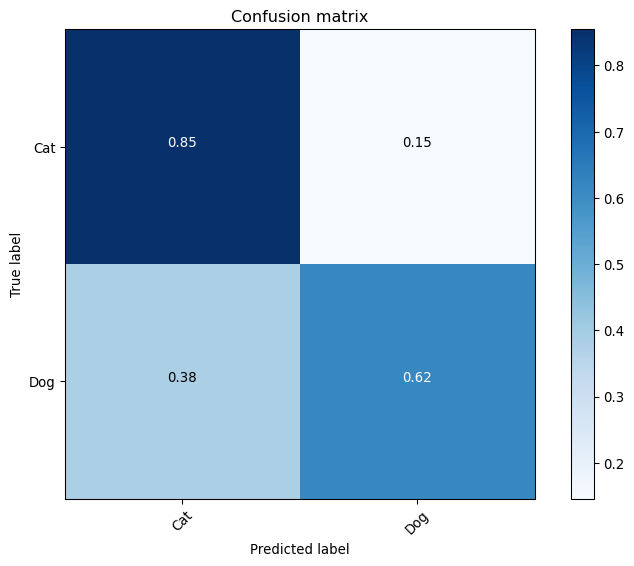

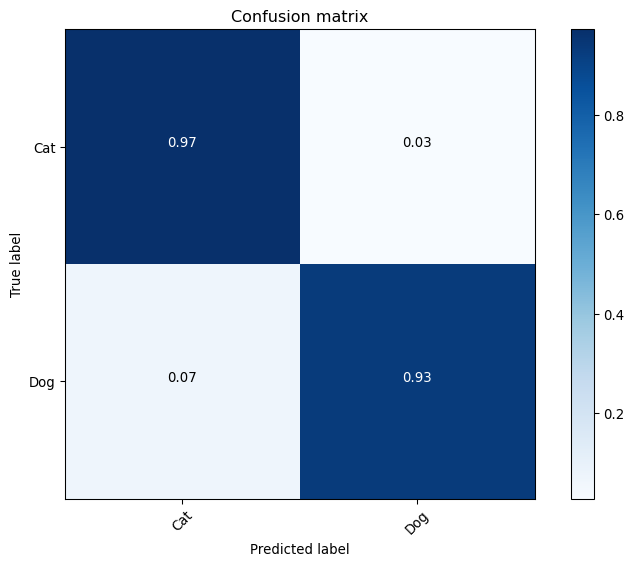

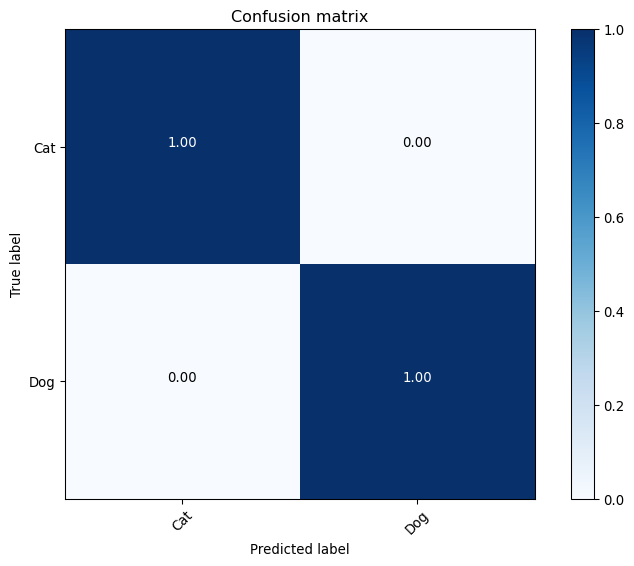

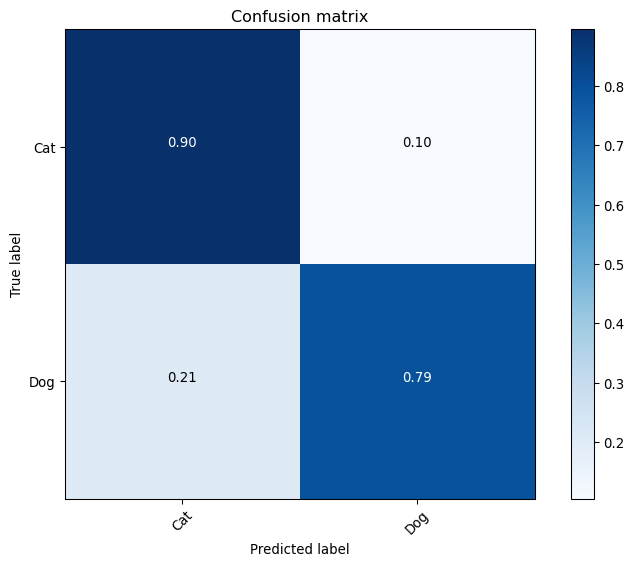

In [11]:
for clf in clfs:
    print(clf)
    print('Valutazione sul training set in corso ...')
    start = time.time()
    train_predictions = clf.predict(train_feature_x)
    print('Valutazione sul training set completata in %.2f s.' % (time.time() - start))
    
    # Calcolo accuratezza
    train_accuracy = (train_predictions == train_y).sum()/len(train_y)
    print('Accuratezza:', train_accuracy)
    
    # Visualizzazione Confusion Matrix
    ml_visualization.plot_confusion_matrix(train_y, train_predictions, ['Cat', 'Dog'])

# Esercizio
L'obiettivo è massimizzare l'accuratezza di classificazione, valutando (con *Cross-Validation*):
- l'impiego di diversi classificatori, come [*k-NN*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [*SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [*Random Forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [*AdaBoost*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) o altri. È possibile utilizzare qualsiasi tipologia di classificatore tranne quelli basati su reti neurali.
- l'ottimizzazione dei relativi iperparametri;
- l'ottimizzazione dei parametri utilizzati per estrarre le feature HOG;
- la combinazione di più classificatori.

Si consiglia di procedere iterativamente a partire da un insieme limitato di combinazioni per poi raffinare la ricerca: infatti, i tempi richiesti per l'esecuzione di [**cross_val_score(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) e [**GridSearchCV(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) possono diventare proibitivi per un elevato numero di combinazioni di iperparametri e *fold*.

**NOTA BENE:**
 - Il classificatore dovrà essere **addestrato e testato sulle feature HOG** estratte dai pattern del dataset (quindi non direttamente sulle immagini originali);
 - Non è (ovviamente) possibile utilizzare i pattern del test set per l'addestramento del classificatore;
 - **Non è consentito aggiungere immagini esterne** al training set così come non è possibile utilizzare immagini derivate (*augmentation*).

In [12]:
# Esercizio 1: ottimizzazione iperparametri
# ...

In [13]:
# SVC
# Creazione di un classificatore di tipo SVM
clf = SVC()

# Creazione della griglia di iperparametri
param_grid = [{'kernel': ['rbf', 'linear'], 'C': [1,2,3,4, 5, 10], 'gamma': [0.05,0.025, 0.5, 0.75]}]

# Numero di fold per la Cross-validation
n_folds = 4

# Creazione di un oggetto di tipo GridSearchCV
grid_search_cv = GridSearchCV(clf, param_grid, cv=n_folds)

# Esecuzione della ricerca degli iperparametri 
grid_search_cv.fit(train_feature_x, train_y)

# Stampa risultati
print('Combinazioni di parametri:\n', grid_search_cv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

Combinazioni di parametri:
 [{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.05, 'kernel': 'linear'}, {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.025, 'kernel': 'linear'}, {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.5, 'kernel': 'linear'}, {'C': 1, 'gamma': 0.75, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.75, 'kernel': 'linear'}, {'C': 2, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 2, 'gamma': 0.05, 'kernel': 'linear'}, {'C': 2, 'gamma': 0.025, 'kernel': 'rbf'}, {'C': 2, 'gamma': 0.025, 'kernel': 'linear'}, {'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}, {'C': 2, 'gamma': 0.5, 'kernel': 'linear'}, {'C': 2, 'gamma': 0.75, 'kernel': 'rbf'}, {'C': 2, 'gamma': 0.75, 'kernel': 'linear'}, {'C': 3, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 3, 'gamma': 0.05, 'kernel': 'linear'}, {'C': 3, 'gamma': 0.025, 'kernel': 'rbf'}, {'C': 3, 'gamma': 0.025, 'kernel': 'linear'}, {'C': 3, 'gamma': 0.5, 'kernel': 'rbf'}, {'C': 3, 'gamma': 0.5, 'kernel': 'linear'}, {'C': 3, 'gamm

In [14]:
# SVC
# Creazione di un classificatore di tipo SVM
clf = RandomForestClassifier()

# Creazione della griglia di iperparametri
param_grid = [{'random_state': [873945], 'n_estimators': [1000], 'max_depth': [None, 4,16,64,32], 'n_jobs': [-1]}]

# Numero di fold per la Cross-validation
n_folds = 5

# Creazione di un oggetto di tipo GridSearchCV
grid_search_cv = GridSearchCV(clf, param_grid, cv=n_folds, verbose=2)

# Esecuzione della ricerca degli iperparametri 
grid_search_cv.fit(train_feature_x, train_y)

# Stampa risultati
print('Combinazioni di parametri:\n', grid_search_cv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   7.6s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.2s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.3s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.3s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.3s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   0.8s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   0.8s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   0.8s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   0.8s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   0.8s
[CV] 

In [15]:
# SVC
# Creazione di un classificatore di tipo SVM
clf = RandomForestClassifier()

# Creazione della griglia di iperparametri
param_grid = [{'random_state': [873945], 'n_estimators': [1000], 'max_depth': [None, 4,16,64,32], 'n_jobs': [-1]}]

# Numero di fold per la Cross-validation
n_folds = 5

# Creazione di un oggetto di tipo GridSearchCV
grid_search_cv = GridSearchCV(clf, param_grid, cv=n_folds, verbose=2)

# Esecuzione della ricerca degli iperparametri 
grid_search_cv.fit(train_feature_x, train_y)

# Stampa risultati
print('Combinazioni di parametri:\n', grid_search_cv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.5s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.5s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.5s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.6s
[CV] END max_depth=None, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.5s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.0s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.0s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.0s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   1.0s
[CV] END max_depth=4, n_estimators=1000, n_jobs=-1, random_state=873945; total time=   0.9s
[CV] 

# Test
Si addestri il classificatore desiderato utilizzando gli iperparametri trovati nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale classificatore per predire la classe dei pattern del dataset di test. Le classi predette verranno salvate su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'accuratezza.
Le procedure utilizzate per caricare i dataset, per estrarne le feature e per addestrare il classificatore desiderato dovranno essere riportate nella cella seguente. Ai fini della competizione si ricorda che nel file .zip dovrà essere inclusa anche una cartella "Codice" contenente una copia di questo notebook e degli script Python utilizzati.

In [16]:
# Esercizio 2: valutazione su test set

# Path contenente i pattern di test
image_side = 128
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt' 
test_filelist = 'Unlabeled_BinaryTestSet.txt'
result_path = 'Es4Predictions.txt'
memory = Memory(exp_path, verbose=0) 

# Caricamento dei pattern di training
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

print('Caricate %d immagini in %.2f s.' % (len(train_raw_x), time.time() - start))
print('Gatti:', np.count_nonzero(train_y == 0))
print('Cani:', np.count_nonzero(train_y == 1))

# Shuffle del training set
ml_utilities.shuffle_in_unison([train_raw_x, train_y], seed=1234)

# Preprocessing ed estrazione HOG (training)
# Resize
print('Resizing in corso ...')
start = time.time()
train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)

print('Resizing completato in %.2f s.' % (time.time() - start))
train_raw_x = [find_edges(i) for i in train_raw_x]
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=False, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                           cache=memory)

# Creazione del classificatore
# clf = ...
clf = RandomForestClassifier(max_depth=16, n_estimators=1000, n_jobs=-1, random_state=873945)

# Addestramento del classificatore
clf.fit(train_feature_x, train_y)

# Caricamento dei pattern di test
test_raw_x = ml_utilities.load_unlabeled_dataset(test_filelist, db_path, cache=memory)

# Preprocessing ed estrazione HOG (test)
print('Resizing in corso ...')
start = time.time()
test_raw_x = ml_utilities.resize_images(test_raw_x, image_side, image_side, cache=memory)

print('Resizing completato in %.2f s.' % (time.time() - start))
test_raw_x = [find_edges(i) for i in test_raw_x]
test_feature_x = ml_utilities.extract_hog(test_raw_x, 
                                           convert_to_gray=False, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                           cache=memory)

# Salvataggio delle predictions
predictions = clf.predict(test_feature_x)

with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Ok')

Caricamento in corso ...
Caricate 900 immagini in 0.15 s.
Gatti: 509
Cani: 391
Resizing in corso ...
Resizing completato in 0.32 s.
Resizing in corso ...
Resizing completato in 0.07 s.
Ok
